from utils import set_pyplot_params
set_pyplot_params()

In questo capitolo presenteremo un problema inspirato ad un quiz televisivo *Il prezzo è giusto*.
E' un esempio stupido, ma ci dimostra un utile processo chiamato [Analisi Decisionale Bayesiana](https://en.wikipedia.org/wiki/Decision_analysis).

Come nell'esempio precedente, useremo i dati e una distribuzione a priori per calcolare una distribuzione a posteriori; poi useremo la distribuzione a posteriori per calcolare una strategia ottimale in un gioco che prevede una offerta.

Come parte della soluzione, useremo la stima della densità del kernel (KDE) per stimare la distribuzione a priori, e la distribuzione normale per calcolare la verosomiglianza del dato.

## Il problema del prezzo è giusto

Il primo novembre del 2007 i concorrenti che chiameremo Letia e Nathianiel apparvero al quiz televisivo *Il prezzo è giusto*.
Essi gareggiarono in un gioco chiamato "La Vetrina" dove l'obiettivo era quello di indovinare il prezzo corretto da un insieme di prezzi. Il concorrente che si avvicina al prezzo corretto, senza superarlo, vince il premio.

Nathaniel è andato per primo, La sua vertrina conteneva una lavapiatti, una cantinetta, un computer portatile e una macchina. La sua offerta fu di \\$26,000.

La vetrina di Letia includeva una flipper, un videogioco, un tavolo da biliardo e una criociera alle Bahamas. La sua offerta fu di \\$21,500.

Il valore della vertrina di Nathaniel era di \\$25,347. Avendo la sua offerta era troppo alta dunque ha perso.
Il valore della vetrina di Letia era di \\$21,578. 

Sbagliando solo di \\$78, lei vinse la sua vetrina e in quanto la sua offerta era sbagliata meno di 250 lei vince anche quella di Nathaniel.

Per un pensatore Bayesiano, questo scenario ci suggerisce le seguenti domande:

1. Prima di vedere i prezzi, quale sono le convinzioni a priori che il partecipante dovrebbe avere circa il prezzo della sua vetrina?

2. Dopo aver visto i prezzi, come dovrebbe aggiornare le prorie credenze il giocatore?

3. Basandosi sulla distribuzione a posteriori, quanto dovrebbero offrire i concorrenti?

La terza domanda ci indirizza verso un uso comune dei metodi Bayesiani: l'analisi decisionale.

Questo problema è inspirato da [un esempio](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb) del libro di Cameron Davidson-Pilon.

## La Distribuzione a priori

Per ottenere una distribuzione di prezzi, possiamo ottenere un vantaggio dai dati degli episodi precedenti. Fortunatamente i fan dello spettacolo hanno segnato i dati di tutte le puntate.

Per prima cosa analizziamo i dati contenenti i dati per ogni vetrina delle stagioni dal 2011 al 2012 e le offerte fatte dai concorrenti.



In [2]:
import pandas as pd

def read_data(filename):
    """Read the showcase price data."""
    df = pd.read_csv(filename, index_col=0, skiprows=[1])
    return df.dropna().transpose()

In [3]:
df2011 = read_data('./data/showcases.2011.csv')
df2012 = read_data('./data/showcases.2012.csv')

df = pd.concat([df2011, df2012], ignore_index=True)

In [4]:
print(df2011.shape, df2012.shape, df.shape)

(191, 6) (122, 6) (313, 6)


Diamo uno sguardo ai dati 

In [5]:
df.head(3)

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0


Le prime due colonne, Showcase 1 e Showcase 2, sono valori delle vetrine in dollari. Le prossime due colonne sono le puntate che i concorrenti hanno fatto. Le ultime due colonne sono le differenze tra il valore della vetrina e le puntate. 

## Kernel Density Estimation

Il dataset contiene i prezzi per le 313 vetrine precedenti, che possiamo pensare come un campione dei possibili prezzi.

Possiamo usare questo campione per stimare la distribuzione a priori delle vetrine dei prezzi. Un modo per farlo è quello di usare la stima della densità del kernel (KDE) che usa il campione per stimare una distribuzione regolare. 

Se non hai familiarità con la stima della densità del kernel puoi [leggere qui](https://mathisonian.github.io/kde).
Scipy fornisce il metodo `gaussian_kde`, che prende un campione e ritorna un oggetto che rappresenta la distribuzione stimata.


La seguente funzione prende in ingresso `sample`, crea un oggetto KDE lo valuta tramite la sequenza di quantità `qs` e ritorna i risultati come una PMF normalizzata.

In [6]:
from scipy.stats import gaussian_kde
from distribution import Pmf

def kde_from_sample(sample, qs):
    """Make a kernel density estimate from a sample."""
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

Qui la stima della distribuzione dei valori del campo Showcase 1:

In [7]:
import numpy as np

qs = np.linspace(0, 80000, 81)
prior1 = kde_from_sample(df['Showcase 1'], qs)

In [8]:
from utils import decorate

def decorate_value(title=''):
    decorate(xlabel='Showcase value ($)',
        ylabel='PMF',
        title=title)

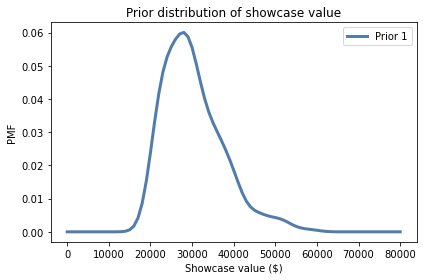

In [9]:
prior1.plot(label='Prior 1')
decorate_value('Prior distribution of showcase value')

Facciamo gli stessi calcoli per il campo  Showcase 2:

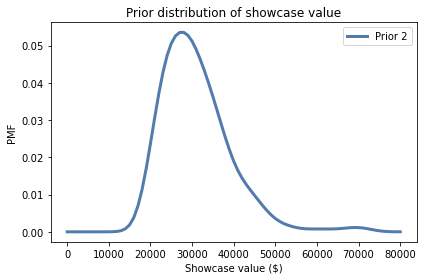

In [10]:
qs = np.linspace(0, 80000, 81)
prior2 = kde_from_sample(df['Showcase 2'], qs)
prior2.plot(label='Prior 2')
decorate_value('Prior distribution of showcase value')

# Distribuzione dell'errore

Per aggiornare queste distribuzioni a priori, dobbiamo rispondere a queste domande:

* Quale dato deve essere considerato e come dobbiamo quantificarlo?

* Possiamo calcolare la funzione di verosomiglianza per ogni ipotetico prezzo, possiamo calcolare la veromiglianza condizionale del dato?

Per rispondere a queste domande, modelerremo ogni partecipante come uno strumento indovina prezzi con caratteristiche di errore conosciute.
In questo modello, quando un partecipante guarda i prezzi esso indovina i prezzi per ogni premio e lo aggiunge ai prezzi.
Chiamiamo questa somma `guess`.

Ora la domanda che ci facciamo è: "Se il prezzo del premio è `price`, quale è la verosomiglianza che la stima del concorrente sia `guess` ?"

Possiamo mettere la domanda in questo modo se definiamo `error = guess - price`, possiamo domandarci, "Quale è la verosomiglianza che la stima del concorrente sia sbagliata di una quantità pari a `error`?"

Per rispondere a questa domanda, Useremo i dati storici ancora.
Per ogni vetrina del dataset, guardiamo la differenza tra l'offerta del concorrente e il prezzo attuale:

In [11]:
sample_diff1 = df['Bid 1'] - df['Showcase 1']
sample_diff2 = df['Bid 2'] - df['Showcase 2']

In [12]:
qs = np.linspace(-40000, 20000, 61)
kde_diff1 = kde_from_sample(sample_diff1, qs)
kde_diff2 = kde_from_sample(sample_diff2, qs)

Mostriamo ora le distribzioni:

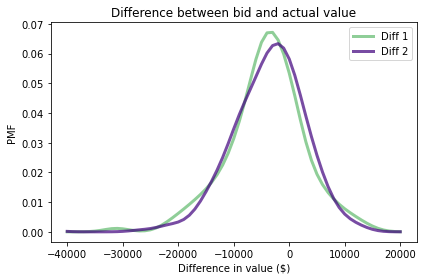

In [13]:
kde_diff1.plot(label='Diff 1', color='C8')
kde_diff2.plot(label='Diff 2', color='C4')

decorate(xlabel='Difference in value ($)',
        ylabel='PMF',
        title='Difference between bid and actual value')

Sembra che le puntate siano più basse che troppo alte e questo ha un senso. Ricordate che la regola principale del gioco è: si perde se la scommessa è troppo alta, dunque i partecipanti tendono a fare offerte più basse volontariamente.

Per esempio, se si pensa che il valore della vetrina sia \\$40,000, la loro offerta sarà di \\$36,000 per evitare di andare sopra.

Sembra che questa distribuzione sia ben modellata da una distribuzione normale, possiamo riassumerla con la media e la deviazione standard.

Come esempio questa è la media e la deviazione standard di `Diff` per il primo giocatore.

In [14]:
mean_diff1 = sample_diff1.mean()
std_diff1 = sample_diff1.std()

print(mean_diff1, std_diff1)

-4116.3961661341855 6899.909806377115


Ora possiamo usare queste differenze per modellare la distribuzione degli errori.
Questo passo è un pochino complicato perchè attualmente conosciamo le ipotesi del concorrente, conosciamo solo le sua puntate.

Dunque facciamo queste assunzioni:

* Assumeremo che i partecipanti sottostimano per questioni strategiche, e in media le loro stime sono accurate. In altre parole, la media dei loro errori è 0.


* Ma assumeremo che che lo spread delle differenze riflette l'attuale spread degli errori. Dunque useremo la deviazione standard delle differenze della deviazione standard degli errori.


Basandosi su queste assunzioni, creeremo una distribuzione normale con paremetri 0 e `std_diff1`.

SciPy ci fornisce un oggetto chiamato `norm` che rappresenta una distribuzione normale con media e deviazione standard data.

In [15]:
from scipy.stats import norm

error_dist1 = norm(0, std_diff1)

Il risultato è un oggetto `pdf` che rappresenta la funzione di densita della probabilità della distribuzione normale.
Per esempio, questa è la densità dellla probabilita di `error=-100`, basata sulla distribuzione degli errori del giocatore 1.



In [16]:
error = -100
error_dist1.pdf(error)

5.7812405640086924e-05

Da solo questo numero non significa molto perchè la densità di probabilità non è una probabilità. Ma esse sono proporzionali alla probabilità, dunque possiamo usarle nell'aggiornamento bayesiano, come vedremo nella prossima sezione.

## Aggiornamento

Supponiamo di essere il giocatore 1.Vediamo il prezzo della nostra vetrina e stimiamo il prezzo di \\$23,000.
Dalla nostra stima sottraiamo ogni ipotetico prezzo della distribuzione a priori, il risultato è il tuo errore sotto ogni ipotesi.



In [17]:
guess1 = 23000
error1 = guess1 - prior1.qs

Ora supponiamo di conoscere basandosi sui risultati passati, che la stima dell'errore sia ben modellata da  `error_dist1`.
Sotto questa assunzione possiamo calcolare la verosomiglianza dell'errore sotto ogni ipotesi.


In [18]:
likelihood1 = error_dist1.pdf(error1)

Il risultato è un array di verosomiglianze, che possiamo usare per aggiornare la distribuzione a priori.

In [19]:
posterior1 = prior1 * likelihood1
posterior1.normalize()

3.3889812097254624e-05

Qui la distribuzione a posteriori 

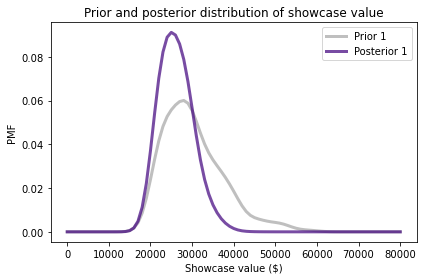

In [20]:
prior1.plot(color='C5', label='Prior 1')
posterior1.plot(color='C4', label='Posterior 1')

decorate_value('Prior and posterior distribution of showcase value')

Visto che la stima iniziale è nella parte bassa dell'intervallo, la distribuzione a posteriori viene spostata verso sinistra. Possiamo calcolare la media della distribuzione a posteriori e vedere di quanto.

In [21]:
prior1.mean(), posterior1.mean()

(30299.488817891375, 26192.02400239254)

Prima di dire i prezzi, ci aspettavamo di vedere una vetrina con un valore vicino a \\$30,000.
Dopo aver fatto la stima di \\$23,000, abbiamo aggiornato la distribuzione a priori.
Basandosi la combinazione della distribuzione a priori e della stime, possiamo aspettarci che il prezzo sia circa di \\$26,000.

Ora supponiamo di essere il giocatore numero 2, quando vediamo la nostra vetrina stimiamo che il prezzo totale sia di  \\$38,000.

Usiamo `diff2` per calcolare la distribuzione normale che rappresenta la distribuzione della stima degli errori.
Calcoliamo la verosomiglianza della nostra stima per ogni prezzo attuale e usiamo per aggiornare `prior2`.

In [22]:
guess2 = 38000
error2 = guess2 - prior2.qs

In [24]:
mean_diff2 = sample_diff2.mean()
std_diff2 = sample_diff2.std()

print(mean_diff2, std_diff2)

error_dist2 = norm(0, std_diff2)
likelihood2 = error_dist2.pdf(error2)

-3675.891373801917 6886.26071132341


In [25]:
posterior2 = prior2 * likelihood2
posterior2.normalize()

2.6978123219107018e-05

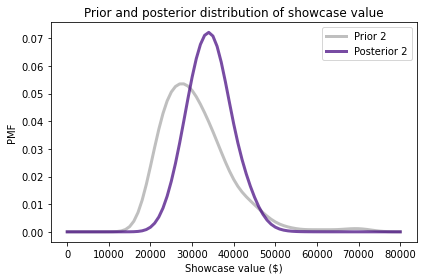

In [26]:
prior2.plot(color='C5', label='Prior 2')
posterior2.plot(color='C4', label='Posterior 2')

decorate_value('Prior and posterior distribution of showcase value')

In [27]:
prior2.mean(), posterior2.mean()

(31047.623719122505, 34305.201616424696)

## Probabilità di vincita

Ora che abbiamo una distribuzione a posteriori per ogni giocatore, pensiamo alla strategia.

Prima, partendo dal punto di vista del giocatore 1, calcoliamo la probabilità che il giocatore 2 sovrastimi. 
Per farla semplice, useremo solo i risultati dei giocatori passati ignorando il valore della vetrina.

La seguente funzione prende una sequenza di puntate passate e ritorna la frazione delle sovrastime.

In [28]:
def prob_overbid(sample_diff):
    """Compute the probability of an overbid."""
    return np.mean(sample_diff > 0)

Qui la stima delle probabilità che il giocatore 2 sovrastimi.

In [29]:
prob_overbid(sample_diff2)

0.29073482428115016

Ora supponiamo che il giocatore 1 sottostimi di \\$5000.
Quale è la probabilità che il giocatore 2 sottostimi di più?

La seguente funzione usa i risultati precedenti per stimare la probabilità che il giocatore sottostimi di più per un ammontare `diff`:

In [30]:
def prob_worse_than(diff, sample_diff):
    """Probability opponent diff is worse than given diff."""
    return np.mean(sample_diff < diff)

Qui la probabilità che il giocatore 2 sottostimi più di \\$5000.

In [31]:
prob_worse_than(-5000, sample_diff2)

0.38338658146964855

E qui la probabilità che stimi più di \\$10,000.

In [32]:
prob_worse_than(-10000, sample_diff2)

0.14376996805111822

Possiamo combinare queste funzioni per calcolare la probabilità che il giocatore 1 vinca , date le differenze tra le puntate e il prezzo attuale:

In [33]:
def compute_prob_win(diff, sample_diff):
    """Probability of winning for a given diff."""
    # if you overbid you lose
    if diff > 0:
        return 0
    
    # if the opponent overbids, you win
    p1 = prob_overbid(sample_diff)
    
    # or of their bid is worse than yours, you win
    p2 = prob_worse_than(diff, sample_diff)
    
    # p1 and p2 are mutually exclusive, so we can add them
    return p1 + p2

Questa è la probabilità che tu vinca, sapendo che la tua sottostima è di \\$5000.

In [34]:
compute_prob_win(-5000, sample_diff2)

0.6741214057507987

Qui la probabilità di vincere per ogni possibile valore

In [35]:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff2) 
      for x in xs]

Qui la visualizzazione:

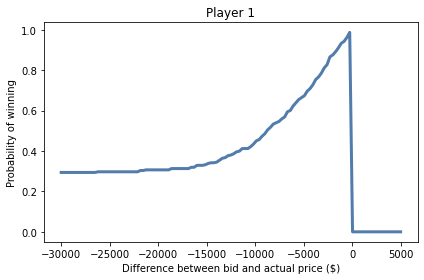

In [36]:
import matplotlib.pyplot as plt

plt.plot(xs, ys)

decorate(xlabel='Difference between bid and actual price ($)',
         ylabel='Probability of winning',
         title='Player 1')

Se sottostimi di \\$30,000 le possibilità di vincita è di circa del 30%, che rappresenta pressochè la possibilità che il concorrente 2 vada in sovrastima. 

Non appena la puntata si avvicina al prezzo reale, le possibilità di vincita si avvicinano a 1.
E ovviamente se se sovrastimiamo tu perdi sempre che il giocatore opposto non sovrastimi pure lui.

Eseguiamo le stesse analisi per il giocatore 2

In [37]:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff1) 
      for x in xs]

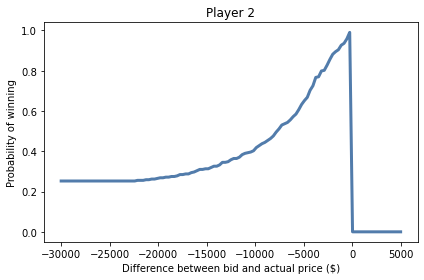

In [39]:
import matplotlib.pyplot as plt

plt.plot(xs, ys)

decorate(xlabel='Difference between bid and actual price ($)',
         ylabel='Probability of winning',
         title='Player 2')

## Massimizazione del guadagno atteso

Nella sezione preceente abbiamo calcolato la puntata che massimizza la possibilità di vincere. 
E se questo è il tuo obiettivo, la puntata calcolata è ottimale.

Ma vincere non è tutto. Ricorda che se la tua puntata ha un errore minore di \\$250 o meno, possiamo vincere entrambe le vetrine. Perciò potrebbe essere interessante aumentare la puntata di un pochino: aumenta le possibilità di fare una sovrastima e perdere, ma aumenta anche la possibilità di vincere entrambe le vetrine. 

Ora vediamo come impostare il problema.
La seguente funzione calcola quanto possiamo vincere, in media, data la nostra puntata il prezzo degli oggetti e un campione di errori del concorrente avversario.

In [40]:
def compute_gain(bid, price, sample_diff):
    """Compute expected gain given a bid and actual price."""
    diff = bid - price
    prob = compute_prob_win(diff, sample_diff)

    # if you are within 250 dollars, you win both showcases
    if -250 <= diff <= 0:
        return 2 * price * prob
    else:
        return price * prob

Per esempio se il prezzo degli oggetti è pari a \\$35000 e la nostra puntata è \\$30000,  vincerai circa \\$23,600 di premi in media, tenendo conto della probabilità di perdere , vincere una vetrina o vincerle entrambe.


In [41]:
compute_gain(30000, 35000, sample_diff2)

23594.249201277955

In realtà non sappiamo il prezzo della vetrina, ma abbiamo la distribuzione a posteriori che rappresenta cosa sappiamo circa lo stesso.

Facendo la media dei prezzi e le probabilità nella distribuzione a posteriori, possiamo calcolare il guadagno che ci aspettiamo per una particolare puntata.

In questo contesto, "aspettato" rappresenta la media di tutte i possibili valori delle vetrine, pesati con le loro probabilità.


In [42]:
def expected_gain(bid, posterior, sample_diff):
    """Compute the expected gain of a given bid."""
    total = 0
    for price, prob in posterior.items():
        total += prob * compute_gain(bid, price, sample_diff)
    return total

Con la distribuzione a posteriori calcolata prima, basandosi sulla puntata di \\$23,000, ci aspettiamo che il guadagno data una punatata di \\$21,000 sia di \\$16,900.

In [43]:
expected_gain(21000, posterior1, sample_diff2)

16923.59933856512

possiamo fare di meglio?
Per trovarlo, possiamo iterare tutti i valori delle puntate per trovare quella che massimizza il guadagno aspettato.

In [44]:
bids = posterior1.qs

gains = [expected_gain(bid, posterior1, sample_diff2) for bid in bids]

expected_gain_series = pd.Series(gains, index=bids)

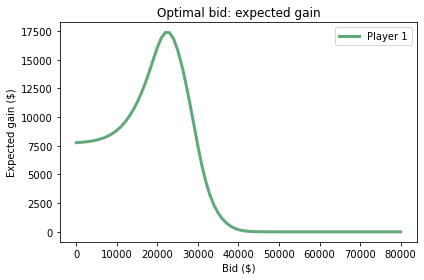

In [45]:
expected_gain_series.plot(label='Player 1', color='C2')

decorate(xlabel='Bid ($)',
         ylabel='Expected gain ($)',
         title='Optimal bid: expected gain')

Qui abbiamo la puntata ottimale.

In [46]:
expected_gain_series.idxmax()

22000.0

Con questa puntata ci aspettiamo un guadagno di \\$17,400.

In [47]:
expected_gain_series.max()

17384.8995844308

Ricordando la stima iniziale era di \\$23,000, la puntata che massimizza la probabilità vincita è di \\$21,000 mentre la puntata che massimizza il guadagno aspettato è \\$22,000.

In [48]:
bids = posterior2.qs

gains = [expected_gain(bid, posterior2, sample_diff1) for bid in bids]
expected_gain_series = pd.Series(gains, index=bids)

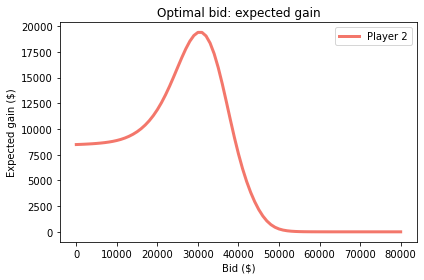

In [50]:
expected_gain_series.plot(label='Player 2', color='C3')

decorate(xlabel='Bid ($)',
         ylabel='Expected gain ($)',
         title='Optimal bid: expected gain')

In [51]:
expected_gain_series.idxmax()

30000.0

In [52]:
expected_gain_series.max()

19404.164188501607

## Riassunto

Abbiamo fatto molte cose in questo capitolo, riassumiamolo in questi passi:

1. Primo passo, abbiamo usato il KDE dei dati passati per stimare la distribuzione a priori per valutare le vetrine.

2. Poi abbiamo usato le puntate passate per modellare la distribuzione degli errori come una distribuzione normale.

3. Abbiamo eseguito l'aggiornamento Byesiano usando la distribuzione degli errori per calcolare la verosomiglianza dei dati.


4. Abbiamo usato la distribuzione a posteriori delle vetrine per calcolare la probabilità di vincere ogni possibile puntata e identificare la puntata che massimizza le possibilità di vittoria.

5. Finalmente, abbiamo usato la probabilità di vittoria per calcolare il guadagno aspettato di ogni possibile puntata e identificato la puntatata con il massimo guadagno.

Accidentalmente, questo esempio dimostra il rischio di usare la parola "ottimale" senza specificare cosa si sta ottimizzando.
La puntata che massimizza la possibilità di vincere non è generalmente la stessa puntata che massimizza il guadagno aspettato.

## Note
Quando le persone discutono sui pro e sui contro delle stime Bayesiane, in contrasto con i classici metodi che alcune volte chiamiamo "frequentisti", spesso affermano che in molti casi i metodi Bayesiani e frequentisti producono gli stessi risultati.
Come opinioni personali questa affermazione è sbagliata perchè i metodi Bayesiani e frequentisti producono differenti *tipi* di risultati:

* Il risultato dei metodi frequentisti è tipicamente un valore singolo ed è considerato la migliore stima (secondo uno dei vari criteri) o un intervallo che quantifica la precisione della stima.

* Il risultato dei metodi Bayesiani è una distribuzione a posteriori che rappresenta tutti i possibili risultati con le loro probabilità. 


Certo, puoi utilizzare la distribuzione a posteriori per scegliere una stima "migliore" o calcolare un intervallo.
E in tal caso il risultato potrebbe essere lo stesso della stima frequentista.

Ma così facendo vengono scartate molte informazioni utili e non andiamo ad usare il beneficio primario dei metodi Bayesiani: la distribuzione a posteriori è più utile di una singola stima o di un intervallo.

Un esempio di questo capitolo ci dimostra il punto,
Usando l'intera distribuzione a posteriori possiamo calcolare la puntata che massimizza la probabilità di vincere o la puntata che massimizza il guadagno aspettato, anche se le regole per il calcolo del guadagno sono complicate e non lineari.

Con una singola stima o un intervallo, non possiamo fare questo. In generale le stime frequentiste provvedono poche indicazioni per le decisioni.